<a href="https://colab.research.google.com/github/SergeyShchus/OSM/blob/main/Notebook/World_rivers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

data http://gaia.geosci.unc.edu/rivers/

The first step is to download the data. The global rivers database can be found here and will be downloaded as a shapefile containing a series of LineStrings corresponding to individual rivers. The best way to load shapefiles with Python is using geopandas, which is pandas with a geospatial element. The data contains a series of values to describe the rivers as well as the rivers geometry.

In [1]:
!pip install pandas fiona shapely pyproj rtree
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 14.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import geopandas as gpd

europ_rivers = gpd.read_file("/content/afrivs.shp")

print(europ_rivers)

           cat     AREA  UP_CELLS  DISCHARGE  WIDTH  WIDTH5  WIDTH95  DEPTH  \
0            1    24.56       142       0.55   5.32    1.94    14.74   0.21   
1            2    34.98       199       0.79   6.38    2.32    17.81   0.25   
2            3    97.00       566       2.25  10.80    3.84    30.78   0.37   
3            4    74.98       111       1.72   9.45    3.38    26.81   0.33   
4            5   408.69       106       9.91  22.66    7.82    66.56   0.66   
...        ...      ...       ...        ...    ...     ...      ...    ...   
566428  566429   295.52       379       1.81   9.69    3.46    27.52   0.34   
566429  566430   676.00      1115      12.32  25.28    8.68    74.57   0.72   
566430  566431  1983.77       830      11.60  24.52    8.43    72.24   0.70   
566431  566432   802.29      1335       4.80  15.77    5.52    45.66   0.50   
566432  566433  1400.37       442       1.37   8.43    3.03    23.81   0.31   

        DEPTH5  DEPTH95   ARCID  \
0         0.10  

Unfortunately, the data does not cope well with lakes. In an ideal world a lake would just be an empty region within the data however because the rivers are derived from topography data which covers the lakes, there are strange features that appear. So a way around this is to find a lakes dataset and with a spatial join, remove these dodgy features from the rivers dataset. Spatial joins between two objects is accomplished with geopandas.sjoin. In a Spatial Join, two geometry objects are merged based on their spatial relationship to one another.
The lake dataset used here comes from NaturalEarth which can be found here. Below, the lakes are loaded as a GeoDataFrame of Polygons which describe each lake. To reduce the amount of data that is being processed, only lakes in Africa are used. This is accomplished by taking a shapefile of the continents (also from NaturalEarth), indexing to remove all but Africa and then spatially joining the lake Polygons with the Africa Polygon to leave African lakes.
After that, the rivers LineStrings are spatially joined with the Africa lakes Polygons to get the dodgy features and then these are removed from the original rivers dataset.

In [31]:
lakes = gpd.read_file("/content/ne_10m_lakes.shp")
country_shapefiles = gpd.read_file("/content/ne_10m_admin_0_countries.shp")
europ = country_shapefiles.loc[country_shapefiles['CONTINENT'] == 'Africa']
europ_lakes = gpd.sjoin(lakes, europ, op='intersects')
europ_lakes = lakes.loc[lakes.index.isin(europ_lakes.index.tolist())]
excluded_rivers = gpd.sjoin(europ_rivers, europ_lakes, op='within')
europ_rivers = europ_rivers.loc[~europ_rivers.index.isin(excluded_rivers.index.tolist())]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):


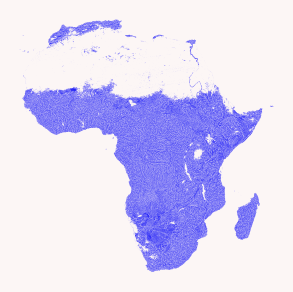

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(5, 7)

europ_rivers.plot(ax=ax, color='blue', lw=0.1)
europ_lakes.plot(ax=ax, color='#FCF6F5FF', alpha=1)

ax.axis('off')

plt.show()

Preparing the River Basins
The next step in this particular exercise is to add the river basins to the plot. River basin Polygons can be found in the hydrosheds database here. The data consists of a series of Polygons/Multipolygons describing the minor and major hydrographical basins of the world. To avoid repetition with the previous section of code I have removed the basins of the rest of the world, keeping only those of Europe and saved that GeoDataFrame to hydrobasins_europe.shp using a spatial join of the worlds basins with a Polygon.

In [ ]:
 lake_victoria = europ_lakes.loc[europ_lakes['name'] == 'Lake Victoria']
 funny_features = gpd.sjoin(europ_rivers, lake_victoria, op='within')

 fig, ax = plt.subplots(facecolor='#FCF6F5FF')
 fig.set_size_inches(5, 7)

 lake_victoria.plot(ax=ax, color='black', alpha=0.1)
 funny_features.plot(ax=ax, color='blue', lw=0.4, alpha=1)

 ax.axis('off')

plt.show()

In [34]:
basins = gpd.read_file("/content/hydrobasins_africa.shp")
print(basins)

      SUB_BAS  TO_BAS  MAJ_BAS       SUB_NAME            MAJ_NAME  SUB_AREA  \
0       90002    -888     7009         Borkou           Lake Chad   1179610   
1       30003   30272     7003   White Nile 5                Nile     97222   
2       90008    -888     7009         Dillia           Lake Chad    162385   
3       30029   30297     7003  Lake Victoria                Nile     69200   
4      100030    -888     7010     Lake Rukwa         Rift Valley      3443   
...       ...     ...      ...            ...                 ...       ...   
1445   153931    -999     7015        Comoros          Madasgacar      2257   
1446   153931    -999     7015        Comoros          Madasgacar      2257   
1447   220781    -999     7022        Cross 1      Gulf of Guinea     51730   
1448   210977    -999     7021         Saloum  Africa, West Coast     41540   
1449   210974    -999     7021       Scarcies  Africa, West Coast     29461   

      MAJ_AREA  LEGEND                             

In [35]:
import pandas as pd

colours_i_like = ['#A1CAF1',  '#875692', '#008856',  '#0067A5', '#BE0032',
                  '#222222', '#848482', '#F3C300',  'blue', '#F38400',
                  '#E68FAC', '#604E97', '#F3C300', '#B3446C', '#C2B280',
                  '#F6A600', '#882D17', '#E25822', '#8DB600',
                  '#F99379',  '#DCD300', '#F3C300', '#E68FAC', '#C2B280',
                  '#222222']

colors_df = pd.DataFrame({'basin': basins.MAJ_NAME.unique().tolist(), 'colors': colours_i_like})

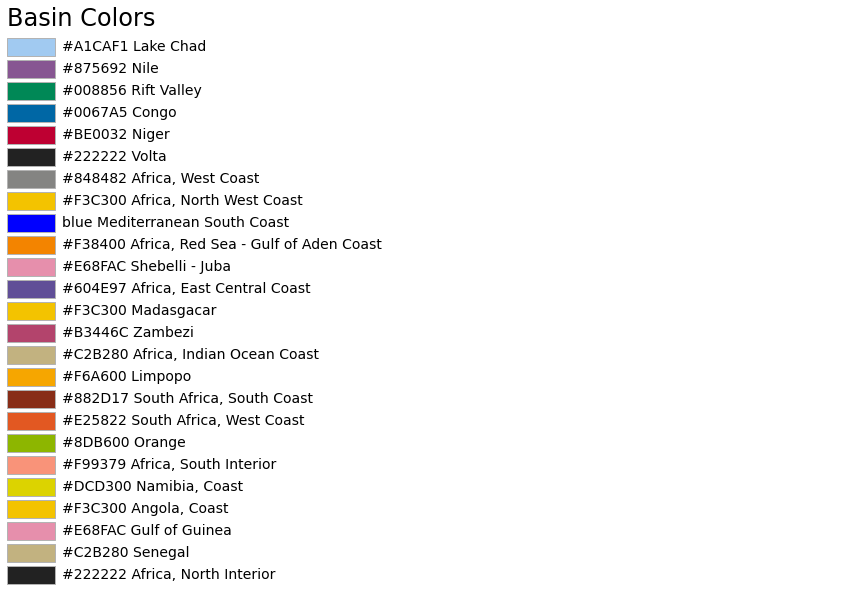

In [40]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


cell_width = 212
cell_height = 22
swatch_width = 48
margin = 12
topmargin = 40

n = len(colours_i_like)
ncols = 1
nrows = len(colours_i_like)
width = cell_width * 4 + 2 * margin
height = cell_height * nrows + margin + topmargin
dpi = 72

fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
fig.subplots_adjust(margin/width, margin/height,
                    (width-margin)/width, (height-topmargin)/height)
ax.set_xlim(0, cell_width * 4)
ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.set_axis_off()
ax.set_title("Basin Colors", fontsize=24, loc="left", pad=10)

for i, (name, basin) in enumerate(zip(colours_i_like, basins.MAJ_NAME.unique().tolist())):
    row = i % nrows
    col = i // nrows
    y = row * cell_height

    swatch_start_x = cell_width * col
    text_pos_x = cell_width * col + swatch_width + 7

    ax.text(text_pos_x, y, (name + " " + basin), fontsize=14,
            horizontalalignment='left',
            verticalalignment='center')

    ax.add_patch(
        Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                  height=18, facecolor=name, edgecolor='0.7')
    )
plt.show()

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


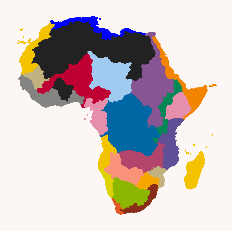

In [41]:
basins = pd.merge(basins, colors_df, left_on='MAJ_NAME', right_on='basin', how='left')

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
basins.plot(ax=ax, column='MAJ_NAME', edgecolor='face', color=basins['colors'])
ax.axis('off')
plt.show()

In [42]:
rivers_basins = gpd.sjoin(europ_rivers, basins, op='intersects')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):


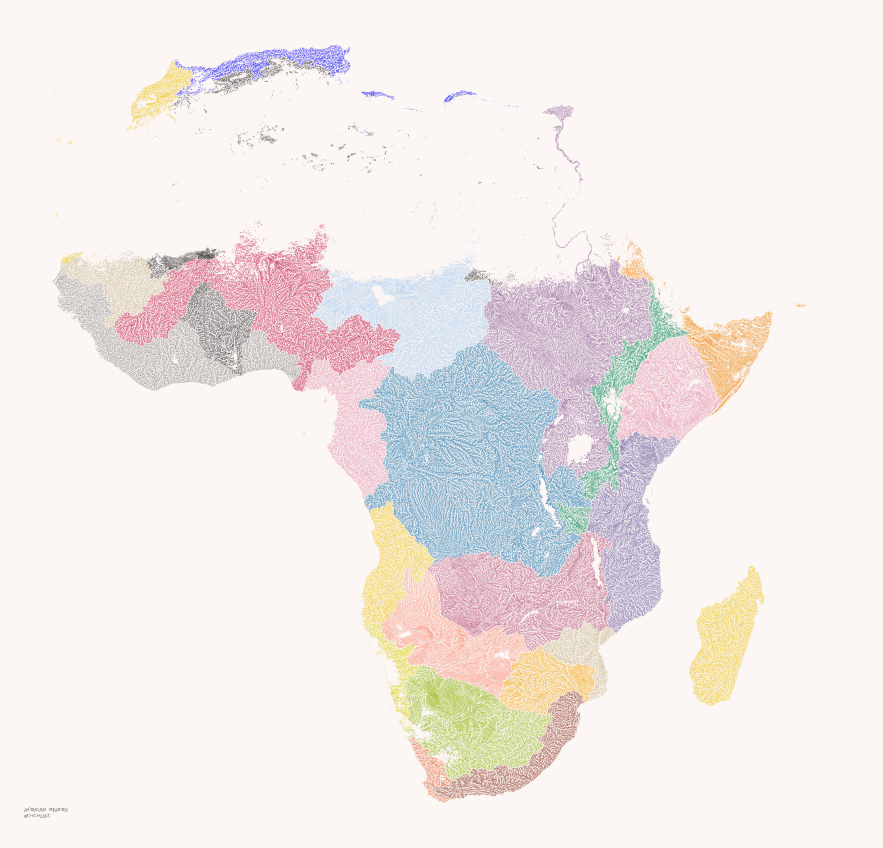

In [56]:

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(15, 20)

rivers_basins.plot(ax=ax, edgecolor='face', color=rivers_basins['colors'], lw=0.2)
europ_lakes.plot(ax=ax, color='#FCF6F5FF')

newax = fig.add_axes([0.83, 0.62, 0.1, 0.1], anchor='NE', zorder=-1)
newax.axis('off')
txt = ax.text(0.02, 0.03, "African Rivers \n@ShchusS",
              size=6,
              color='grey',
              transform = ax.transAxes,
              fontfamily='fantasy')

ax.axis('off')
plt.show()

In [ ]:
plt.savefig('/content/outputs/African_Rivers.png', dpi = 300)

In [59]:
import numpy as np

def scale_lw(df: gpd.GeoDataFrame, column_name: str, min_value: float = 0.005, max_value: float = 0.6):
    leftSpan = np.amax(df[column_name]) - np.amin(df[column_name])
    rightSpan = 0.6 - 0.005
    valueScaled = (df[column_name] - np.amin(df[column_name])) / leftSpan
    df[f'LW_{column_name}'] = 0.005 + (valueScaled * rightSpan)
    return df

rivers_basins = scale_lw(rivers_basins, 'DISCHARGE', min_value=0.005, max_value=0.6)
rivers_basins = scale_lw(rivers_basins, 'WIDTH', min_value=0.005, max_value=0.6)
rivers_basins = scale_lw(rivers_basins, 'DEPTH', min_value=0.005, max_value=0.6)

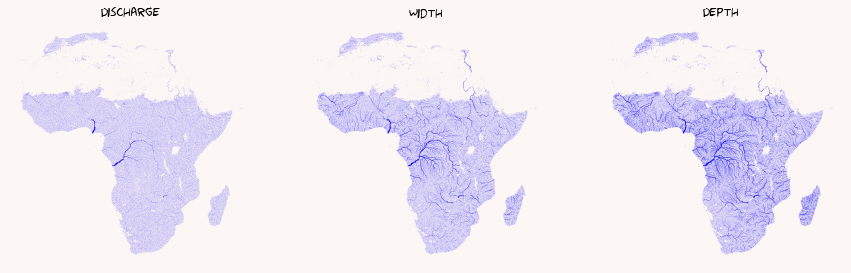

In [61]:
import matplotlib.pyplot as plt

fig = plt.figure(facecolor='#FCF6F5FF')
fig.set_size_inches(15, 7)

ax1 = plt.subplot(1,3,1)
rivers_basins.plot(ax=ax1, color='blue', lw=rivers_basins['LW_DISCHARGE'])
europ_lakes.plot(ax=ax1, color='#FCF6F5FF')
ax1.set_title("Discharge", fontfamily='fantasy')
ax1.axis('off')

ax2 = plt.subplot(1,3,2)
rivers_basins.plot(ax=ax2, color='blue', lw=rivers_basins['LW_WIDTH'])
europ_lakes.plot(ax=ax2, color='#FCF6F5FF')
ax2.set_title("Width", fontfamily='fantasy')
ax2.axis('off')

ax3 = plt.subplot(1,3,3)
rivers_basins.plot(ax=ax3, color='blue', lw=rivers_basins['LW_DEPTH'])
europ_lakes.plot(ax=ax3, color='#FCF6F5FF')
ax3.set_title("Depth", fontfamily='fantasy')
ax3.axis('off')

plt.show()

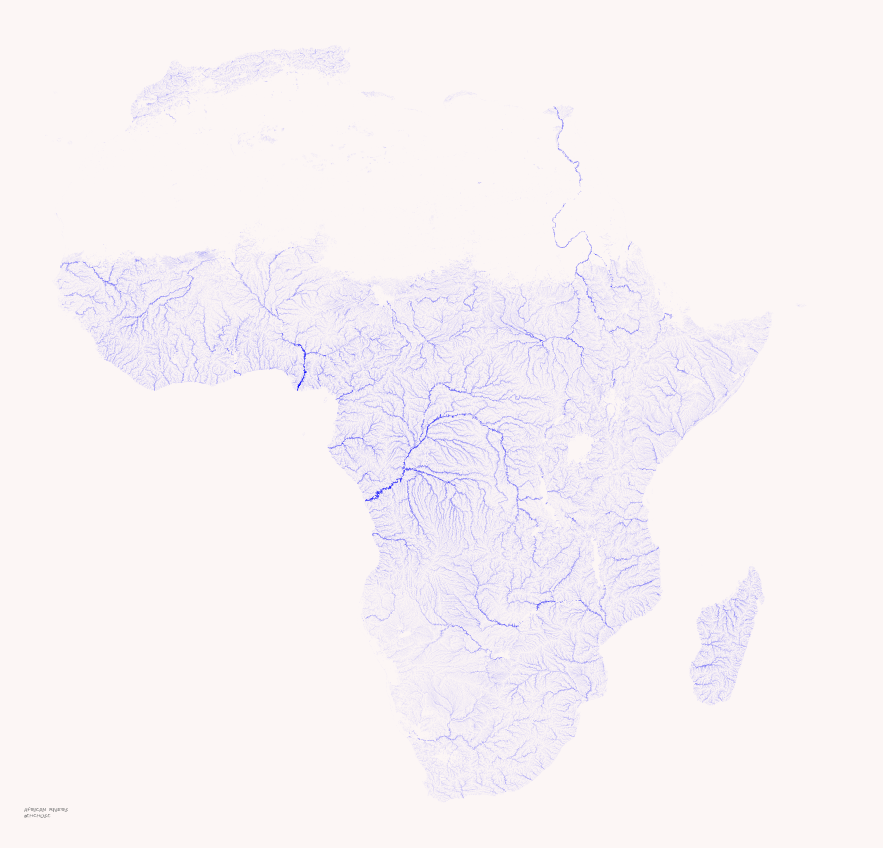

In [62]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(15, 20)


rivers_basins.plot(ax=ax, edgecolor='face', color='blue', lw=rivers_basins['LW_DEPTH'])
europ_lakes.plot(ax=ax, color='#FCF6F5FF')

newax = fig.add_axes([0.83, 0.62, 0.1, 0.1], anchor='NE', zorder=-1)
newax.axis('off')
txt = ax.text(0.02, 0.03, "African Rivers \n@ShchusS",
              size=6,
              color='grey',
              transform = ax.transAxes,
              fontfamily='fantasy')

ax.axis('off')
plt.show()

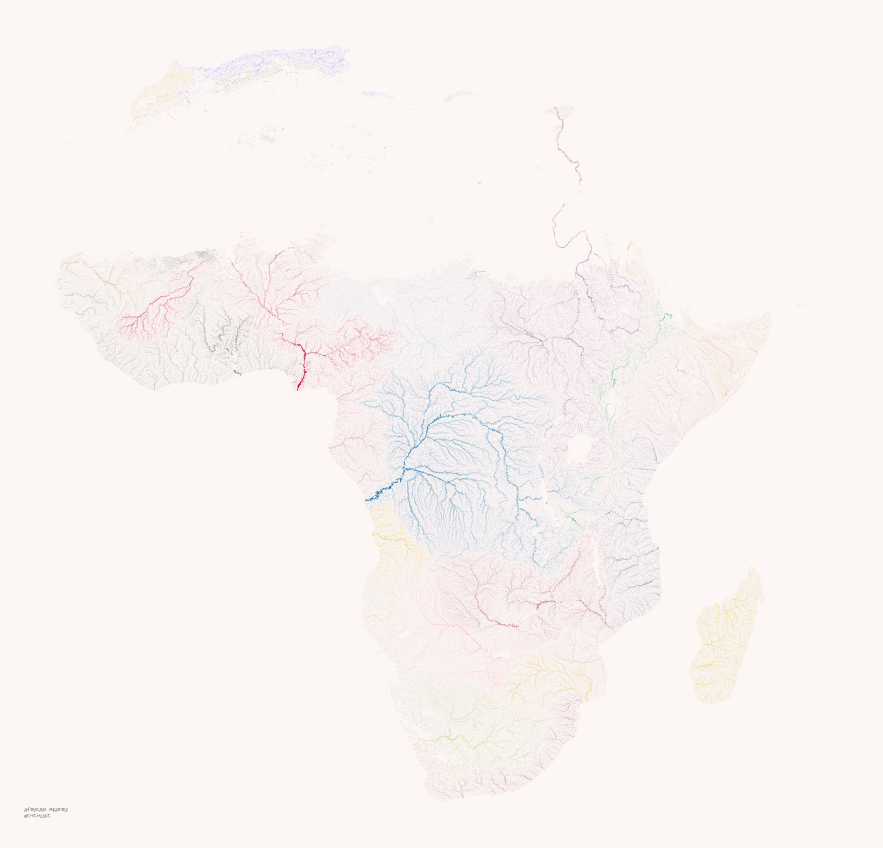

In [63]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(15, 20)


rivers_basins.plot(ax=ax, edgecolor='face', color=rivers_basins['colors'], lw=rivers_basins['LW_DEPTH'])
europ_lakes.plot(ax=ax, color='#FCF6F5FF')

newax = fig.add_axes([0.83, 0.62, 0.1, 0.1], anchor='NE', zorder=-1)
newax.axis('off')
txt = ax.text(0.02, 0.03, "African Rivers \n@ShchusS",
              size=6,
              color='grey',
              transform = ax.transAxes,
              fontfamily='fantasy')

ax.axis('off')
plt.show()

In [65]:


rivers = gpd.read_file("/content/eurivs.shp")

print(rivers)

           cat   a_cat  a_ARCID  a_UP_CELLS    a_AREA  a_WIDTH  a_WIDTH5  \
0            1    3441     3441         343    106.40    15.61      5.47   
1            2    3449     3449         138   1061.67    56.59     18.82   
2            3    3453     3453         102    106.58    15.62      5.47   
3            4    3454     3454         264     78.62    13.44      4.73   
4            5    3467     3467         108  49596.01   389.90    120.02   
...        ...     ...      ...         ...       ...      ...       ...   
449703  449704  494471   494471         803    398.50    22.47      7.75   
449704  449705  494471   494471         803    398.50    22.47      7.75   
449705  449706  494991   494991        4670   1116.35    37.74     12.75   
449706  449707  495054   495054        3796   1235.64    39.72     13.40   
449707  449708  378514   378514         897   1662.84    46.12     15.46   

        a_WIDTH95  a_DEPTH  a_DEPTH5  a_DEPTH95  b_cat  b_value b_label  \
0           

In [66]:
country_shapefiles = gpd.read_file("/content/ne_10m_admin_0_countries.shp")
print(country_shapefiles)

          featurecla  scalerank  LABELRANK                    SOVEREIGNT  \
0    Admin-0 country          0          2                     Indonesia   
1    Admin-0 country          0          3                      Malaysia   
2    Admin-0 country          0          2                         Chile   
3    Admin-0 country          0          3                       Bolivia   
4    Admin-0 country          0          2                          Peru   
..               ...        ...        ...                           ...   
253  Admin-0 country          0          4                         China   
254  Admin-0 country          6          5                     Australia   
255  Admin-0 country          6          8  Bajo Nuevo Bank (Petrel Is.)   
256  Admin-0 country          6          5               Serranilla Bank   
257  Admin-0 country          6          6              Scarborough Reef   

    SOV_A3  ADM0_DIF  LEVEL               TYPE TLC  \
0      IDN         0      2  Sove

In [67]:
lakes = gpd.read_file("/content/ne_10m_lakes.shp")
europ = country_shapefiles.loc[country_shapefiles['ADMIN'] == 'Ukraine']
europ_lakes = gpd.sjoin(lakes, europ, op='intersects')
europ_lakes = lakes.loc[lakes.index.isin(europ_lakes.index.tolist())]
excluded_rivers = gpd.sjoin(rivers, europ_lakes, op='within')
rivers = rivers.loc[~rivers.index.isin(excluded_rivers.index.tolist())]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):


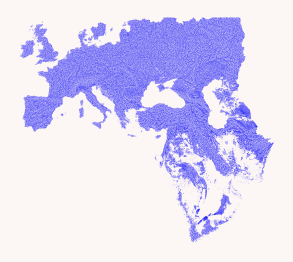

In [68]:

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(5, 7)

rivers.plot(ax=ax, color='blue', lw=0.1)
europ_lakes.plot(ax=ax, color='#FCF6F5FF', alpha=1)

ax.axis('off')

plt.show()